#### Predection PAs
<small> looking at the two prior seasons

In [38]:
# packages and file import
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

# wd
os.chdir('C:/Users/dalto/OneDrive/Pictures/Documents/Projects/MLB Season Model/')

In [39]:
pa_data = pd.read_csv('./data/cleaned/pa_injury_data.csv')
pa_data = pa_data.drop(columns=['Unnamed: 0'])

#### Change to Two Year Format

In [40]:
# List to collect results
combined_rows = []

# Numeric columns to sum/average (excluding Name and Season)
numeric_cols = pa_data.select_dtypes(include=[np.number]).columns.tolist()

for name, group in pa_data.groupby('Name'):
    group_sorted = group.sort_values('Season')
    for i in range(len(group_sorted) - 1):
        row1 = group_sorted.iloc[i]
        row2 = group_sorted.iloc[i + 1]
        # New season label
        season_label = f"{int(row1['Season'])}_{int(row2['Season'])}"
        # Sum and average numeric columns
        summed = row1[numeric_cols] + row2[numeric_cols]
        averaged = summed / 2
        # Build new row
        new_row = {'Name': name, 'Season': season_label}
        for col in numeric_cols:
            new_row[col] = averaged[col]
        combined_rows.append(new_row)

# Create DataFrame
pa_data = pd.DataFrame(combined_rows)

# round season up, being last season in df
pa_data['Season'] = np.ceil(pa_data['Season'])
pa_data.head()

,Name,Season,PA,Age,Days_Missed_Season
0,aaron hicks,2022.0,289.5,31.5,71.5
1,aaron hicks,2023.0,382.5,32.5,19.0
2,aaron hicks,2024.0,187.5,33.5,19.0
3,aaron judge,2022.0,664.5,29.5,5.5
4,aaron judge,2023.0,577.0,30.5,32.5


#### Normalize

In [41]:
def mean_year(group):
        avg = np.average(group, weights=group.index.map(lambda x: pa_data.loc[x, 'PA']))
        return avg

In [42]:
def calculate_weighted_std(group):
    avg = np.average(group, weights=group.index.map(lambda x: pa_data.loc[x, 'PA']))
    variance = np.average((group - avg)**2, weights=group.index.map(lambda x: pa_data.loc[x, 'PA']))
    return np.sqrt(variance)

In [43]:
def z_scores(player_df, mean_df, std_df):
    # z scores for each stat and player, also creating a new df flow, add back names based on MLBAMID later
    z_scores = pd.DataFrame(index=player_df.index, columns=player_df.select_dtypes(include=[np.number]).columns)

    # scaled for each col
    for col in player_df.select_dtypes(include=[np.number]).columns:
        if col not in ['Season', 'MLBAMID']:  # not needed
            for idx in player_df.index:
                season = player_df.loc[idx, 'Season']
                value = player_df.loc[idx, col]
                mean = mean_df.loc[mean_df['Season'] == season, col].iloc[0]
                std = std_df.loc[std_df['Season'] == season, col].iloc[0]
                # scale so that 10 is 1 std away
                z_scores.loc[idx, col] = 100 + ((value - mean) / std * 10)

    z_scores['Season'] = player_df['Season']
    
    # cols to numeric
    for col in z_scores.columns:
        if col not in ['Season', 'MLBAMID']:
            z_scores[col] = pd.to_numeric(z_scores[col])
    
    # reinsert player names
    z_scores.insert(0, 'Name', player_df['Name']) 

    return z_scores

mean

In [44]:
# df to store mean results
mean_values = pd.DataFrame(index=pa_data['Season'].unique())

for col in pa_data.select_dtypes(include=[np.number]).columns:
    if col != 'Season' and col != 'MLBAMID':  # skip meaningless numeric
        yearly_mean = pa_data.groupby('Season')[col].apply(mean_year)
        mean_values[col] = yearly_mean

# reset and rename index
mean_values = mean_values.reset_index()
mean_values = mean_values.rename(columns={'index': 'Season'})

# sort and display
mean_values = mean_values.sort_values(by=['Season'])
mean_values.head()

,Season,PA,Age,Days_Missed_Season
0,2022.0,432.210729,28.468247,20.592738
1,2023.0,434.651288,28.217884,17.308084
2,2024.0,443.200804,28.050456,16.807920


std

In [45]:
# Create empty DataFrame to store results
std_values = pd.DataFrame(index=pa_data['Season'].unique())

# Loop through numeric columns
for col in pa_data.select_dtypes(include=[np.number]).columns:
    if col != 'Season' and col != 'MLBAMID':  # skip meaningless numeric
        yearly_std = pa_data.groupby('Season')[col].apply(calculate_weighted_std)
        std_values[col] = yearly_std

std_values = std_values.reset_index()
std_values = std_values.rename(columns={'index': 'Season'})

std_values = std_values.sort_values(by=['Season'])
std_values.head()

,Season,PA,Age,Days_Missed_Season
0,2022.0,166.075188,3.435303,23.161135
1,2023.0,170.625973,3.602468,22.360954
2,2024.0,166.679151,3.562068,21.683031


zscore

In [46]:
df_zscore = z_scores(pa_data, mean_df=mean_values, std_df=std_values)
df_zscore.head()

,Name,Season,PA,Age,Days_Missed_Season
0,aaron hicks,2022.0,91.406860,108.825286,121.979606
1,aaron hicks,2023.0,96.943532,111.886618,100.756638
2,aaron hicks,2024.0,84.659101,115.298822,101.010966
3,aaron judge,2022.0,113.986994,103.003383,93.483593
4,aaron judge,2023.0,108.342734,106.334868,106.793948


#### xgboost model

In [47]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error

get next year PA

In [48]:
for idx in df_zscore.index:
    # retrive name, season
    name = df_zscore.loc[idx, 'Name']
    season = df_zscore.loc[idx, 'Season']
    # full df
    next_year = pa_data[(pa_data['Name'] == name) & (pa_data['Season'] == season + 1)]
    # add to df
    if not next_year.empty:
        df_zscore.loc[idx, 'next_pa'] = next_year['PA'].iloc[0] # need for later anaylsis

df_zscore_train = df_zscore.dropna(subset=['next_pa'])

#### model training loop

In [49]:
X = df_zscore_train.drop(columns=['Name', 'Season', 'next_pa'])
y = df_zscore_train['next_pa']

In [50]:
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2)

In [51]:
model = xgb.XGBRegressor(n_estimators = 100, random_state = 26)
model.fit(train_x, train_y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=26, ...)

##### hyperparameter search

random search

In [52]:
from sklearn.model_selection import RandomizedSearchCV

In [53]:
rnd_search_params = {
    'learning_rate': np.linspace(0.05, 0.2, 4),          
    'max_leaves': np.linspace(1, 40, 20, dtype=int),     
    'min_child_weight': np.linspace(1, 20, 10),         
    'subsample': np.linspace(0.3, 0.9, 7),               
    'colsample_bytree': np.linspace(0.4, 1, 7),          
    'early_stopping_rounds': np.linspace(10, 100, 10, dtype=int),  
    'max_depth': np.linspace(0, 40, 20, dtype=int)       
}

rnd_searcher = RandomizedSearchCV(model, rnd_search_params, random_state=26, n_iter=1000, cv=5, n_jobs=-1, verbose=4)
rnd_searcher.fit(train_x, train_y, eval_set=[(test_x, test_y)])
print(rnd_searcher.best_params_)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


KeyboardInterrupt: 

grid search

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
grid_search_params = {
    'learning_rate': [0.05, 0.1],   
    'max_leaves': [22, 25, 28],
    'min_child_weight': [10, 12, 14],      
    'subsample': [0.35, 0.4, 0.45],           
    'colsample_bytree':[0.9, 1],     
    'early_stopping_rounds':[25, 30, 40],
    'max_depth': [ 4, 5, 6]
}
grid_searcher = GridSearchCV(model, grid_search_params, cv=5, n_jobs=-1, verbose=4)
grid_searcher.fit(train_x, train_y, eval_set=[(test_x, test_y)])
print(grid_searcher.best_params_)

Fitting 5 folds for each of 972 candidates, totalling 4860 fits
[0]	validation_0-rmse:9.99536
[1]	validation_0-rmse:9.64936
[2]	validation_0-rmse:9.31917
[3]	validation_0-rmse:9.02730
[4]	validation_0-rmse:8.72738


c:\Users\dalto\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


[5]	validation_0-rmse:8.46957
[6]	validation_0-rmse:8.20438
[7]	validation_0-rmse:7.96909
[8]	validation_0-rmse:7.75460
[9]	validation_0-rmse:7.55886
[10]	validation_0-rmse:7.37715
[11]	validation_0-rmse:7.19669
[12]	validation_0-rmse:7.04512
[13]	validation_0-rmse:6.90764
[14]	validation_0-rmse:6.74943
[15]	validation_0-rmse:6.62525
[16]	validation_0-rmse:6.51373
[17]	validation_0-rmse:6.40659
[18]	validation_0-rmse:6.32077
[19]	validation_0-rmse:6.24252
[20]	validation_0-rmse:6.15930
[21]	validation_0-rmse:6.09388
[22]	validation_0-rmse:6.02979
[23]	validation_0-rmse:5.98712
[24]	validation_0-rmse:5.94513
[25]	validation_0-rmse:5.89022
[26]	validation_0-rmse:5.85218
[27]	validation_0-rmse:5.80558
[28]	validation_0-rmse:5.76425
[29]	validation_0-rmse:5.72144
[30]	validation_0-rmse:5.68194
[31]	validation_0-rmse:5.65907
[32]	validation_0-rmse:5.63295
[33]	validation_0-rmse:5.60665
[34]	validation_0-rmse:5.59402
[35]	validation_0-rmse:5.57464
[36]	validation_0-rmse:5.55615
[37]	validati

In [54]:
opti_para = {'colsample_bytree': 1, 'early_stopping_rounds': 25, 'learning_rate': 0.05, 'max_depth': 4, 'max_leaves': 22, 'min_child_weight': 14, 'subsample': 0.45}
model.set_params(**opti_para)
model.fit(train_x, train_y, eval_set=[(test_x, test_y)])

[0]	validation_0-rmse:180.28184
[1]	validation_0-rmse:174.28497
[2]	validation_0-rmse:168.72707
[3]	validation_0-rmse:162.88275


[4]	validation_0-rmse:157.50170
[5]	validation_0-rmse:152.73434
[6]	validation_0-rmse:148.07076
[7]	validation_0-rmse:143.84774
[8]	validation_0-rmse:140.16722
[9]	validation_0-rmse:136.47659
[10]	validation_0-rmse:133.20421
[11]	validation_0-rmse:129.90449
[12]	validation_0-rmse:127.13601
[13]	validation_0-rmse:124.39371
[14]	validation_0-rmse:121.97431
[15]	validation_0-rmse:119.70470
[16]	validation_0-rmse:117.61465
[17]	validation_0-rmse:115.84502
[18]	validation_0-rmse:114.13318
[19]	validation_0-rmse:112.64129
[20]	validation_0-rmse:111.17526
[21]	validation_0-rmse:109.81777
[22]	validation_0-rmse:108.59356
[23]	validation_0-rmse:107.47590
[24]	validation_0-rmse:106.38440
[25]	validation_0-rmse:105.42759
[26]	validation_0-rmse:104.52814
[27]	validation_0-rmse:103.68609
[28]	validation_0-rmse:103.06533
[29]	validation_0-rmse:102.38713
[30]	validation_0-rmse:101.75773
[31]	validation_0-rmse:101.17355
[32]	validation_0-rmse:100.59529
[33]	validation_0-rmse:100.20240
[34]	validation_

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             device=None, early_stopping_rounds=25, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=22, min_child_weight=14, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, random_state=26, ...)

##### results

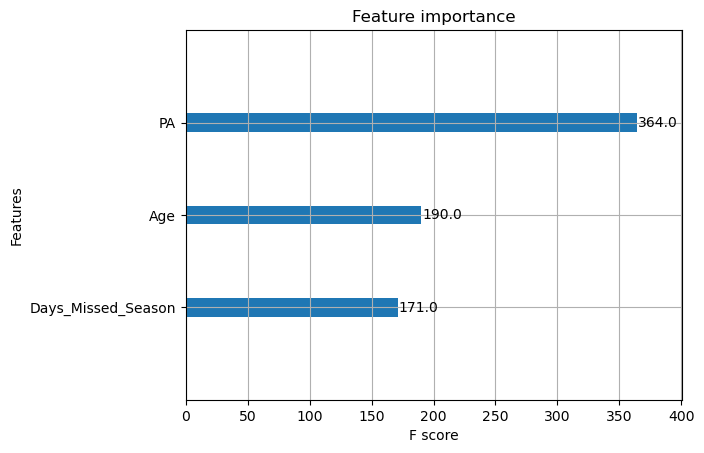

In [55]:
xgb.plot_importance(model)
plt.show()

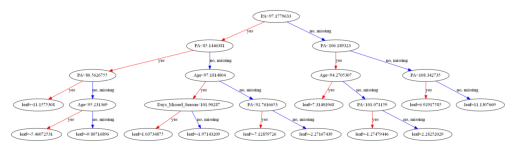

In [56]:
xgb.plot_tree(model, num_trees=3)
plt.show()

In [57]:
from sklearn.metrics import r2_score

results = model.predict(test_x)
rmse = root_mean_squared_error(y_pred=results, y_true=test_y)
r2 = r2_score(test_y, results)
print("R^2:", r2)
print(rmse)

R^2: 0.7272315185305734
97.6974946641213


2025 Predections

In [58]:
pred_2025 = df_zscore[df_zscore['Season'] == 2024]
x_predections = pred_2025.drop(columns=['Name', 'Season', 'next_pa'])
xgb_final_preds = model.predict(x_predections)

In [59]:
pred_2025['pred_pa'] = xgb_final_preds
pred_2025 = pred_2025.drop(columns=['next_pa'])
export_pred = pred_2025[['Name', 'pred_pa']]
export_pred = export_pred.reset_index()
export_pred = export_pred.drop(columns='index')
export_pred.to_csv('./data/2025_Predections/pa_25_2.csv')

C:\Users\dalto\AppData\Local\Temp\ipykernel_30164\869927444.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_2025['pred_pa'] = xgb_final_preds
